## DL4US Final Project - KADOWAKI Shuhei
### prj 1. Create a Street-Classifier
The classifier predicts *where each input street photograph is taken*,   with trasfer-learning or fine-tuning of VGG16 trained on [Places365 dataset designed by MIT](http://places2.csail.mit.edu/).  
e.g.) "This street is in Kyoto!"  

### prj 2. Interpret the learning results
Furthermore, if the fine-tuned network achieves good results, I want to interpret *how those results come*, using **[Grad-CAM](https://qiita.com/icoxfog417/items/8689f943fd1225e24358)** method.  
e.g.) "This street is in Kyoto, *because of its absolutely cool atmosphere and beautiful people and and ...*"

### Preparation

#### authorize the access to my Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/G')
!ls G/'My Drive'/dl4us/prj

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/G
aviatesk.docx  demo.png		hists	       notebook.ipynb	   refs     src
aviatesk.pdf   demo_result.png	~$iatesk.docx  notebook_sub.ipynb  results
data	       figs		models	       __pycache__	   run.py


In [0]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from PIL import Image
from tqdm import tqdm

dir_path = os.path.join('G', 'My Drive', 'dl4us', 'prj')
gc_path = os.path.join('.')
print('dir_path:', dir_path)
print('gc_path:', gc_path)
sys.path.append(os.path.join(dir_path, 'src'))

dir_path: G/My Drive/dl4us/prj
gc_path: .


In [0]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

#### set target cities

In [0]:
cities = ('london', 'moscow', 'nyc', 'paris', 'vancouver', 'beijing', 'kyoto',
          'seoul', 'singapore', 'tokyo')

#### unzip data

In [0]:
!unzip G/'My Drive'/dl4us/prj/data/processed/processed_data.zip
!ls

Archive:  G/My Drive/dl4us/prj/data/processed/processed_data.zip
  inflating: beijing.npy             
  inflating: kyoto.npy               
  inflating: london.npy              
  inflating: moscow.npy              
  inflating: nyc.npy                 
  inflating: paris.npy               
  inflating: seoul.npy               
  inflating: singapore.npy           
  inflating: tokyo.npy               
  inflating: vancouver.npy           
beijing.npy  kyoto.npy	 moscow.npy  paris.npy	  seoul.npy	 tokyo.npy
G	     london.npy  nyc.npy     sample_data  singapore.npy  vancouver.npy


#### check data 

In [0]:
from utils import show_data

for city_name in cities:
    city_data = np.load(os.path.join(gc_path, city_name + '.npy'))
    show_data(city_name, city_data, num_show=7)
    plt.show()

del city_data

Output hidden; open in https://colab.research.google.com to view.

### SVM on the Extracted Deep Features

In [0]:
import time
from extract import extract_gc
from load_data import set_extracted_data
from sklearn.svm import SVC
from utils import report

dir_name = 'svm-on-extracted-features'

Using TensorFlow backend.


#### without augmentation

##### extract and set the extracted data


In [0]:
s0 = time.time()

extracted_data = extract_gc(
    cities,
    gc_path=gc_path,
    weights='imagenet',
    pooling='avg',
    test_size=0.2,
    random_state=42,
    augment=False,
    verbose=0,
)

(X_pld_train, X_pld_test), (X_npld_train, X_npld_test), (y1_train, y1_test), (
    y2_train, y2_test), (label2class1, label2class2) = set_extracted_data(
        extracted_data, cities=cities, verbose=1)

e0 = time.time()
print('{:.2f} min used for extraction:'.format((e0 - s0) / 60))

- test_size: 0.2 - augment: False - augment_mode: 0 augment_times: 1
58892288/58889256 [==============================] - 3s 0us/step
extracting london data ...
extracting moscow data ...
extracting nyc data ...
extracting paris data ...
extracting vancouver data ...
extracting beijing data ...
extracting kyoto data ...
extracting seoul data ...
extracting singapore data ...
extracting tokyo data ...
returned: (X_pld_train, X_pld_test), (X_npld_train, X_npld_test), (y1_train, y1_test), (y2_train, y2_test), (label2class1, label2class2)
X_pld_train: (3317, 512)
X_pld_test: (834, 512)
X_npld_train: (3317, 25088)
X_npld_test: (834, 25088)
y1_train: (3317,)
y1_test: (834,)
y2_train: (3317,)
y2_test: (834,)
label2class1: [(0, 'western'), (1, 'eastern')]
label2class2: [(0, 'london'), (1, 'moscow'), (2, 'nyc'), (3, 'paris'), (4, 'vancouver'), (5, 'beijing'), (6, 'kyoto'), (7, 'seoul'), (8, 'singapore'), (9, 'tokyo')]
1.94 min used for extraction:


##### classify and report


###### pooled data

----- train -----
accuracy: 0.9451 %
             precision    recall  f1-score   support

    western     0.9456    0.9489    0.9472      1721
    eastern     0.9447    0.9411    0.9429      1596

avg / total     0.9451    0.9451    0.9451      3317

----- test -----
accuracy: 0.7962 %
             precision    recall  f1-score   support

    western     0.8138    0.7875    0.8005       433
    eastern     0.7783    0.8055    0.7917       401

avg / total     0.7968    0.7962    0.7962       834

figure saved successfully to G/My Drive/dl4us/prj/figs/svm-on-extracted-features/category1-pooled-noaugmentation-imagenet.png


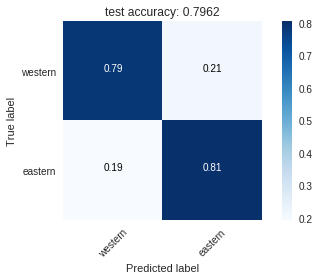

0.20 min used for category1-pooled-noaugmentation-imagenet:

----- train -----
accuracy: 0.8903 %
             precision    recall  f1-score   support

     london     0.8607    0.8987    0.8793       385
     moscow     0.9424    0.9175    0.9298       303
        nyc     0.8723    0.9005    0.8862       402
      paris     0.9078    0.9052    0.9065       348
  vancouver     0.7829    0.9046    0.8393       283
    beijing     0.9017    0.8991    0.9004       347
      kyoto     0.9249    0.9480    0.9363       442
      seoul     0.8920    0.7908    0.8383       282
  singapore     0.9738    0.8455    0.9051       220
      tokyo     0.8797    0.8393    0.8591       305

avg / total     0.8926    0.8903    0.8904      3317

----- test -----
accuracy: 0.4688 %
             precision    recall  f1-score   support

     london     0.4141    0.4227    0.4184        97
     moscow     0.4848    0.4211    0.4507        76
        nyc     0.4845    0.4653    0.4747       101
      paris   

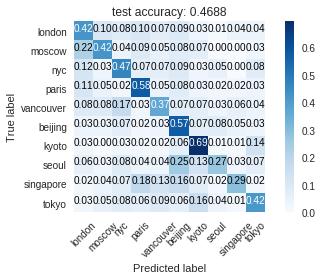

0.32 min used for category2-pooled-noaugmentation-imagenet:

0.51 min used for pooled-noaugmentation-imagenet:


In [0]:
base_name = 'pooled-noaugmentation-imagenet'

s1 = time.time()

model = SVC(kernel='rbf', C=1.0)
model.fit(X_pld_train, y1_train)
y1_train_pred = model.predict(X_pld_train)
y1_test_pred = model.predict(X_pld_test)

classes1 = [c for label, c in label2class1]
report(
    y1_train,
    y1_train_pred,
    'train',
    classes1,
)
fig_name = 'category1-' + base_name
report(
    y1_test,
    y1_test_pred,
    'test',
    classes1,
    dir_path=dir_path,
    dir_name=dir_name,
    fig_name=fig_name)

e1 = time.time()
print('{:.2f} min used for {}:'.format((e1 - s1) / 60, fig_name), end='\n\n')

s2 = time.time()

model = SVC(kernel='rbf', C=1.0)
model.fit(X_pld_train, y2_train)
y2_train_pred = model.predict(X_pld_train)
y2_test_pred = model.predict(X_pld_test)

classes2 = [c for label, c in label2class2]
report(y2_train, y2_train_pred, 'train', classes2)
fig_name = 'category2-' + base_name
report(
    y2_test,
    y2_test_pred,
    'test',
    classes2,
    dir_path=dir_path,
    dir_name=dir_name,
    fig_name=fig_name)

e2 = time.time()
print('{:.2f} min used for {}:'.format((e2 - s2) / 60, fig_name), end='\n\n')

print('{:.2f} min used for {}:'.format((e2 - s1) / 60, base_name))

###### non-pooled data

In [0]:
base_name = 'nonpooled-nonaugmentation'

s1 = time.time()

model = SVC(kernel='rbf')
model.fit(X_npld_train, y1_train)

y1_train_pred = model.predict(X_npld_train)
y1_test_pred = model.predict(X_npld_test)

classes1 = [c for l, c in label2class1]
report(y1_train, y1_train_pred, 'train', classes1)
fig_name = 'category1-' + base_name
report(
    y1_test,
    y1_test_pred,
    'test',
    classes1,
    dir_path=dir_path,
    dir_name=dir_name,
    fig_name=fig_name)

e1 = time.time()
print('{:.2f} min used for {}:'.format((e1 - s1) / 60, fig_name), end='\n\n')

s2 = time.time()

model = SVC(kernel='rbf')
model.fit(X_npld_train, y2_train)

y2_train_pred = model.predict(X_npld_train)
y2_test_pred = model.predict(X_npld_test)

classes2 = [c for l, c in label2class2]
report(y2_train, y2_train_pred, 'train', classes2)
fig_name = 'category2-' + base_name
report(
    y2_test,
    y2_test_pred,
    'test',
    classes2,
    dir_path=dir_path,
    dir_name=dir_name,
    fig_name=fig_name)

e2 = time.time()
print('{:.2f} min used for {}:'.format((e2 - s2) / 60, fig_name), end='\n\n')

print('{:.2f} min used for {}:'.format((e2 - s1) / 60, base_name))

#### with augmentation

##### extract and set the extracted data


In [0]:
for augment_mode in (0, 1):
    for augment_times in (1, 5):

        base_name = 'pooled-augment_mode{}-augment_times{}'.format(
            augment_mode, augment_times)

        s0 = time.time()

        extracted_data = extract_gc(
            cities,
            gc_path=gc_path,
            weights='places',
            pooling='avg',
            test_size=0.2,
            random_state=42,
            augment=True,
            augment_mode=augment_mode,
            augment_times=augment_times,
            verbose=0,
        )

        (X_pld_train, X_pld_test), (y1_train, y1_test), (y2_train, y2_test), (
            label2class1, label2class2) = set_extracted_data(
                extracted_data, cities=cities, verbose=0)

        e0 = time.time()
        print(
            '{:.2f} min used for extraction:'.format((e0 - s0) / 60),
            end='\n\n')

        s1 = time.time()

        model = SVC(kernel='rbf', C=1.0)
        model.fit(X_pld_train, y1_train)
        y1_train_pred = model.predict(X_pld_train)
        y1_test_pred = model.predict(X_pld_test)

        classes1 = [c for label, c in label2class1]
        report(
            y1_train,
            y1_train_pred,
            'train',
            classes1,
        )
        plt.grid(None)
        fig_name = 'category1-' + base_name
        report(
            y1_test,
            y1_test_pred,
            'test',
            classes1,
            dir_path=dir_path,
            dir_name=dir_name,
            fig_name=fig_name)

        e1 = time.time()
        print(
            '{:.2f} min used for {}:'.format((e1 - s1) / 60, fig_name),
            end='\n\n')

        s2 = time.time()

        model = SVC(kernel='rbf', C=1.0)
        model.fit(X_pld_train, y2_train)
        y2_train_pred = model.predict(X_pld_train)
        y2_test_pred = model.predict(X_pld_test)

        classes2 = [c for label, c in label2class2]
        report(y2_train, y2_train_pred, 'train', classes2)
        plt.grid(None)
        fig_name = 'category2-' + base_name
        report(
            y2_test,
            y2_test_pred,
            'test',
            classes2,
            dir_path=dir_path,
            dir_name=dir_name,
            fig_name=fig_name)

        e2 = time.time()
        print(
            '{:.2f} min used for {}:'.format((e2 - s2) / 60, fig_name),
            end='\n\n')

        print('{:.2f} min used for {}:'.format((e2 - s1) / 60, base_name),
             end='\n\n')

### Experiment with ImageNet VGG16 and Random-Initialized VGG16

#### import and set meta settings

In [0]:
from load_data import set_data_gc
from load_model import create_model, set_fine_tune
from set_generator import create_generator_gc, get_test_data
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from callbacks import SnapShot, Logger
from utils import report, save_model
from keras.models import load_model

# meta settings
batch_size = 128
augment_times = 5
print('batch_size:', batch_size)
print('augment_times:', augment_times)

Using TensorFlow backend.


batch_size: 128
augment_times: 5


#### set data

In [0]:
set_data_gc(
    gc_path=gc_path,
    cities=cities,
    test_size=0.1,
    validation_size=0.15,
    random_state=42,
    verbose=1,
)

  0%|          | 0/10 [00:00<?, ?it/s]


processing london training data ...
processing london validation data ...
processing london test data ...


 10%|█         | 1/10 [00:11<01:41, 11.30s/it]


processing moscow training data ...
processing moscow validation data ...
processing moscow test data ...


 20%|██        | 2/10 [00:20<01:24, 10.57s/it]


processing nyc training data ...
processing nyc validation data ...
processing nyc test data ...


 30%|███       | 3/10 [00:31<01:16, 10.91s/it]


processing paris training data ...
processing paris validation data ...
processing paris test data ...


 40%|████      | 4/10 [00:41<01:03, 10.64s/it]


processing vancouver training data ...
processing vancouver validation data ...
processing vancouver test data ...


 50%|█████     | 5/10 [00:49<00:48,  9.76s/it]


processing beijing training data ...
processing beijing validation data ...
processing beijing test data ...


 60%|██████    | 6/10 [00:56<00:35,  8.94s/it]


processing kyoto training data ...
processing kyoto validation data ...
processing kyoto test data ...


 70%|███████   | 7/10 [01:06<00:27,  9.32s/it]


processing seoul training data ...
processing seoul validation data ...
processing seoul test data ...


 80%|████████  | 8/10 [01:15<00:17,  8.98s/it]


processing singapore training data ...
processing singapore validation data ...
processing singapore test data ...


 90%|█████████ | 9/10 [01:21<00:08,  8.20s/it]


processing tokyo training data ...
processing tokyo validation data ...
processing tokyo test data ...


100%|██████████| 10/10 [01:30<00:00,  8.49s/it]


all data saving has been done successfully


385


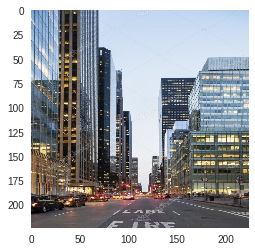

In [0]:
# 385 and the image of buildings in NYC should be shown below
plt.grid(None)
plt.imshow(Image.open(os.path.join(gc_path, 'data', 'train', 'nyc', '1.png')))
!ls -l -1 data/train/nyc/ | wc -l

#### ImageNet VGG16: transfer-learning

58892288/58889256 [==============================] - 11s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________

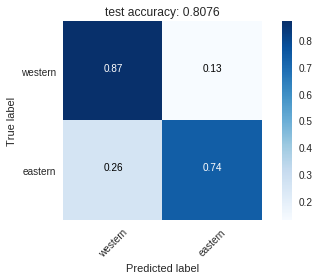

----- test -----
accuracy: 0.5558 %
             precision    recall  f1-score   support

     london     0.5600    0.5714    0.5657        49
     moscow     0.4364    0.6316    0.5161        38
        nyc     0.5952    0.4902    0.5376        51
      paris     0.5962    0.7045    0.6458        44
  vancouver     0.4878    0.5556    0.5195        36
    beijing     0.6222    0.6364    0.6292        44
      kyoto     0.7500    0.6429    0.6923        56
      seoul     0.6000    0.3333    0.4286        36
  singapore     0.6522    0.5357    0.5882        28
      tokyo     0.3333    0.3846    0.3571        39

avg / total     0.5710    0.5558    0.5562       421

figure saved successfully to G/My Drive/dl4us/prj/figs/transfered/category2-512-avg-0.5vs1-imagenet.final.png


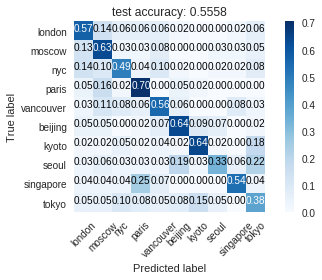

Found 421 images belonging to 10 classes.
----- test -----
accuracy: 0.8076 %
             precision    recall  f1-score   support

    western     0.7819    0.8716    0.8243       218
    eastern     0.8427    0.7389    0.7874       203

avg / total     0.8112    0.8076    0.8065       421

figure saved successfully to G/My Drive/dl4us/prj/figs/transfered/category1-512-avg-0.5vs1-imagenet.best.png


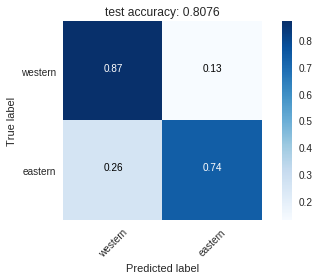

----- test -----
accuracy: 0.5558 %
             precision    recall  f1-score   support

     london     0.5600    0.5714    0.5657        49
     moscow     0.4364    0.6316    0.5161        38
        nyc     0.5952    0.4902    0.5376        51
      paris     0.5962    0.7045    0.6458        44
  vancouver     0.4878    0.5556    0.5195        36
    beijing     0.6222    0.6364    0.6292        44
      kyoto     0.7500    0.6429    0.6923        56
      seoul     0.6000    0.3333    0.4286        36
  singapore     0.6522    0.5357    0.5882        28
      tokyo     0.3333    0.3846    0.3571        39

avg / total     0.5710    0.5558    0.5562       421

figure saved successfully to G/My Drive/dl4us/prj/figs/transfered/category2-512-avg-0.5vs1-imagenet.best.png


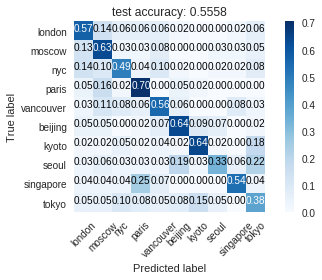

In [0]:
dir_name = 'transfered'
units, pooling, loss_weights = 512, 'avg', (0.5, 1)
base_name = '{}-{}-{}vs{}-imagenet'.format(units, pooling, *loss_weights)

model = create_model(
    n_class2=len(cities),
    n_class1=2,
    weights='imagenet',
    pooling=pooling,
    units=units,
    drop_rate=0.5,
    optimizer='nadam',
    loss_weights=loss_weights,
)
model.summary()

train_gen, default_steps, (label2class1, label2class2) = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='train',
    batch_size=batch_size,
    random_state=42,
)
steps_per_epoch = default_steps * augment_times
valid_gen, validation_steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='validate',
    batch_size=batch_size,
    random_state=42,
)

epochs = 50
rlr = ReduceLROnPlateau(
    monitor='val_output2_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=2)
ss = SnapShot(
    dir_path, dir_name, base_name, monitor='val_output2_acc', mode='max')
cl = Logger(dir_path, dir_name, base_name)

hist = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[
        rlr,
        ss,
        cl,
    ],
    verbose=2,
)

######## test below #######

X_test, (y1_test, y2_test), (label2class1, label2class2) = get_test_data(
    gc_path=gc_path,
    cities=cities,
    batch_size=batch_size,
    random_state=42,
)

classes1 = [c for l, c in label2class1]
classes2 = [c for l, c in label2class2]

### test with the final model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.final'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.final'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### test with the best model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

model = load_model(
    os.path.join(dir_path, 'models', dir_name, base_name + '.best.h5'))

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.best'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.best'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

#### ImageNet VGG16: fine-tuning

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

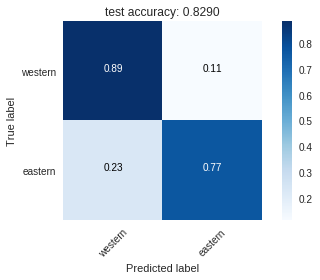

----- test -----
accuracy: 0.5606 %
             precision    recall  f1-score   support

     london     0.5200    0.5306    0.5253        49
     moscow     0.4510    0.6053    0.5169        38
        nyc     0.5652    0.5098    0.5361        51
      paris     0.6038    0.7273    0.6598        44
  vancouver     0.4722    0.4722    0.4722        36
    beijing     0.6500    0.5909    0.6190        44
      kyoto     0.7407    0.7143    0.7273        56
      seoul     0.7368    0.3889    0.5091        36
  singapore     0.5556    0.5357    0.5455        28
      tokyo     0.3778    0.4359    0.4048        39

avg / total     0.5746    0.5606    0.5608       421

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category2-512-avg-0.5vs1-imagenet-15.final.png


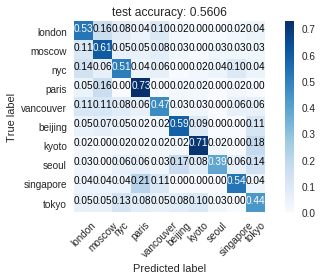

Found 421 images belonging to 10 classes.
----- test -----
accuracy: 0.8242 %
             precision    recall  f1-score   support

    western     0.8025    0.8761    0.8377       218
    eastern     0.8525    0.7685    0.8083       203

avg / total     0.8266    0.8242    0.8235       421

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category1-512-avg-0.5vs1-imagenet-15.best.png


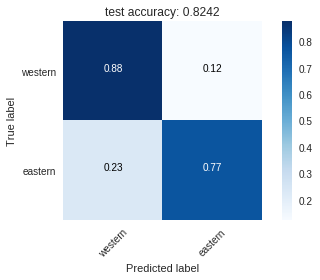

----- test -----
accuracy: 0.5748 %
             precision    recall  f1-score   support

     london     0.5091    0.5714    0.5385        49
     moscow     0.4583    0.5789    0.5116        38
        nyc     0.6047    0.5098    0.5532        51
      paris     0.6400    0.7273    0.6809        44
  vancouver     0.4857    0.4722    0.4789        36
    beijing     0.6512    0.6364    0.6437        44
      kyoto     0.7407    0.7143    0.7273        56
      seoul     0.7143    0.4167    0.5263        36
  singapore     0.5926    0.5714    0.5818        28
      tokyo     0.4000    0.4615    0.4286        39

avg / total     0.5864    0.5748    0.5754       421

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category2-512-avg-0.5vs1-imagenet-15.best.png


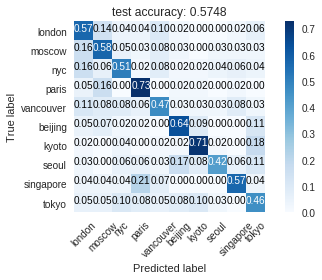

In [0]:
base_name = '512-avg-0.5vs1-imagenet'

model_file_path = os.path.join(dir_path, 'models', 'transfered', base_name + '.best.h5')
freeze = 15

model = set_fine_tune(
    model_file_path,
    freeze=freeze,
    # optimizer=SGD(lr=1e-4, momentum=0.9, nesterov=True),
    loss_weights=None, # gonna use the same weights
)
model.summary()

dir_name = 'fine-tuned' # change dir_name
base_name = '{}-{}'.format(base_name, freeze) # change base_name

train_gen, default_steps, (label2class1, label2class2) = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='train',
    batch_size=batch_size,
    random_state=42,
)
steps_per_epoch = default_steps * augment_times
valid_gen, validation_steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='validate',
    batch_size=batch_size,
    random_state=42,
)

epochs = 100
rlr = ReduceLROnPlateau(
    monitor='val_output2_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=2,
)
ss = SnapShot(
    dir_path, dir_name, base_name, monitor='val_output2_acc', mode='max')
cl = Logger(dir_path, dir_name, base_name, add=True)

hist = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[
        rlr,
        ss,
        cl,
    ],
    verbose=2,
)

######## test below #######

X_test, (y1_test, y2_test), (label2class1, label2class2) = get_test_data(
    gc_path=gc_path,
    cities=cities,
    batch_size=batch_size,
    random_state=42,
)

classes1 = [c for l, c in label2class1]
classes2 = [c for l, c in label2class2]

### test with the final model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.final'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.final'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### test with the best model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

model = load_model(
    os.path.join(dir_path, 'models', dir_name, base_name + '.best.h5'))

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.best'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.best'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

#### Random-Initialized VGG16: just with VGG16 architecture

In [0]:
dir_name = 'fine-tuned'
units, pooling, loss_weights = 512, 'avg', (0.5, 1)
base_name = '{}-{}-{}vs{}-random'.format(units, pooling, *loss_weights)

model = create_model(
    n_class2=len(cities),
    n_class1=2,
    weights=None,
    pooling=pooling,
    units=units,
    drop_rate=0.5,
    optimizer='nadam',
    loss_weights=loss_weights,
)
model.summary()

train_gen, default_steps, (label2class1, label2class2) = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='train',
    batch_size=batch_size,
    random_state=42,
)
steps_per_epoch = default_steps * augment_times
valid_gen, validation_steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='validate',
    batch_size=batch_size,
    random_state=42,
)

epochs = 50
ss = SnapShot(
    dir_path, dir_name, base_name, monitor='val_output2_acc', mode='max')
cl = Logger(dir_path, dir_name, base_name, add=True)

hist = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[
        ss,
        cl,
    ],
    verbose=2,
)

save_model(dir_path, dir_name, base_name + '.final', model)

######## test below #######

X_test, (y1_test, y2_test), (label2class1, label2class2) = get_test_data(
    gc_path=gc_path,
    cities=cities,
    batch_size=batch_size,
    random_state=42,
)

classes1 = [c for l, c in label2class1]
classes2 = [c for l, c in label2class2]

### test with the final model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.final'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.final'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### test with the best model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

model = load_model(
    os.path.join(dir_path, 'models', dir_name, base_name + '.best.h5'))

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.best'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.best'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

In [0]:
dir_name = 'fine-tuned'
units, pooling, loss_weights = 512, 'avg', (0.5, 1)
base_name = '{}-{}-{}vs{}-random'.format(units, pooling, *loss_weights)

model = load_model(os.path.join(dir_path, 'models', dir_name, '512-avg-0.5vs1-random.best.h5'))
model.summary()

train_gen, default_steps, (label2class1, label2class2) = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='train',
    batch_size=batch_size,
    random_state=42,
)
steps_per_epoch = default_steps * augment_times
valid_gen, validation_steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='validate',
    batch_size=batch_size,
    random_state=42,
)

epochs = 63
ss = SnapShot(
    dir_path, dir_name, base_name, monitor='val_output2_acc', mode='max')
cl = Logger(dir_path, dir_name, base_name, add=True)

hist = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[
        ss,
        cl,
    ],
    verbose=2,
)

######## test below #######

X_test, (y1_test, y2_test), (label2class1, label2class2) = get_test_data(
    gc_path=gc_path,
    cities=cities,
    batch_size=batch_size,
    random_state=42,
)

classes1 = [c for l, c in label2class1]
classes2 = [c for l, c in label2class2]

### test with the final model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.final'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.final'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### test with the best model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

model = load_model(
    os.path.join(dir_path, 'models', dir_name, base_name + '.best.h5'))

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.best'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.best'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### Experiment with Changing the Target Cities and Random State

#### import and set meta

In [0]:
from load_data import set_data_gc
from load_model import create_model, set_fine_tune
from set_generator import create_generator_gc, get_test_data
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from callbacks import SnapShot, Logger
from utils import report, save_model
from keras.models import load_model

# meta settings
batch_size = 128
augment_times = 5
print('batch_size:', batch_size)
print('augment_times:', augment_times)

Using TensorFlow backend.


batch_size: 128
augment_times: 5


#### set data

In [0]:
# cities = ('london', 'moscow', 'nyc', 'paris', 'vancouver', 'beijing', 'kyoto',
#           'seoul', 'singapore', 'tokyo')
cities = ('london', 'nyc', 'paris', 'vancouver', 'beijing', 'kyoto',
          'singapore', 'tokyo')

set_data_gc(
    gc_path=gc_path,
    cities=cities,
    test_size=0.1,
    validation_size=0.15,
    # random_state=42,
    random_state=41,
    verbose=1,
)

  0%|          | 0/8 [00:00<?, ?it/s]


processing london training data ...
processing london validation data ...
processing london test data ...


 12%|█▎        | 1/8 [00:10<01:12, 10.33s/it]


processing nyc training data ...
processing nyc validation data ...
processing nyc test data ...


 25%|██▌       | 2/8 [00:19<00:59,  9.90s/it]


processing paris training data ...
processing paris validation data ...
processing paris test data ...


 38%|███▊      | 3/8 [00:26<00:46,  9.25s/it]


processing vancouver training data ...
processing vancouver validation data ...
processing vancouver test data ...


 50%|█████     | 4/8 [00:33<00:33,  8.33s/it]


processing beijing training data ...
processing beijing validation data ...
processing beijing test data ...


 62%|██████▎   | 5/8 [00:44<00:27,  9.10s/it]


processing kyoto training data ...
processing kyoto validation data ...
processing kyoto test data ...


 75%|███████▌  | 6/8 [00:58<00:21, 10.70s/it]


processing singapore training data ...
processing singapore validation data ...
processing singapore test data ...


 88%|████████▊ | 7/8 [01:03<00:08,  8.92s/it]


processing tokyo training data ...
processing tokyo validation data ...
processing tokyo test data ...


100%|██████████| 8/8 [01:10<00:00,  8.34s/it]


all data saving has been done successfully


385


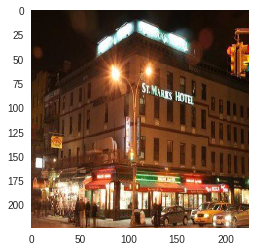

In [0]:
# 385 and the image of buildings in NYC should NOT be shown below if random_state == 42
# 385 and the night corner in NYC should be shown below if random_state == 41
plt.grid(None)
plt.imshow(Image.open(os.path.join(gc_path, 'data', 'train', 'nyc', '1.png')))
!ls -l -1 data/train/nyc/ | wc -l

#### transfer-learning

58916864/58909656 [==============================] - 12s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
___________________________________________

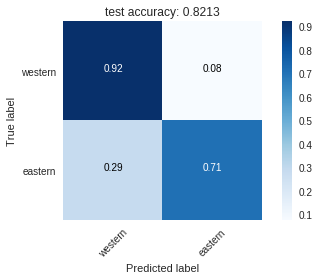

----- test -----
accuracy: 0.5476 %
             precision    recall  f1-score   support

     london     0.4096    0.6939    0.5152        49
        nyc     0.4615    0.7059    0.5581        51
      paris     0.7037    0.4318    0.5352        44
  vancouver     0.4615    0.3333    0.3871        36
    beijing     0.5909    0.5909    0.5909        44
      kyoto     0.7872    0.6607    0.7184        56
  singapore     0.7000    0.5000    0.5833        28
      tokyo     0.5455    0.3077    0.3934        39

avg / total     0.5826    0.5476    0.5450       347

figure saved successfully to G/My Drive/prj/figs/transfered/category2-512-avg-0.5vs1-random_state41-8cities.final.png


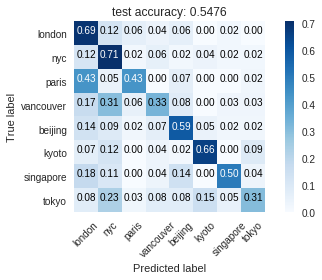

Found 347 images belonging to 8 classes.
----- test -----
accuracy: 0.7983 %
             precision    recall  f1-score   support

    western     0.7806    0.8500    0.8138       180
    eastern     0.8212    0.7425    0.7799       167

avg / total     0.8001    0.7983    0.7975       347

figure saved successfully to G/My Drive/prj/figs/transfered/category1-512-avg-0.5vs1-random_state41-8cities.best.png


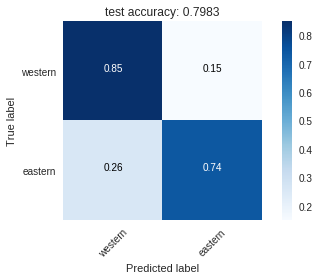

----- test -----
accuracy: 0.5360 %
             precision    recall  f1-score   support

     london     0.4103    0.6531    0.5039        49
        nyc     0.5357    0.5882    0.5607        51
      paris     0.7727    0.3864    0.5152        44
  vancouver     0.3500    0.3889    0.3684        36
    beijing     0.5345    0.7045    0.6078        44
      kyoto     0.8222    0.6607    0.7327        56
  singapore     0.5909    0.4643    0.5200        28
      tokyo     0.4615    0.3077    0.3692        39

avg / total     0.5710    0.5360    0.5359       347

figure saved successfully to G/My Drive/prj/figs/transfered/category2-512-avg-0.5vs1-random_state41-8cities.best.png


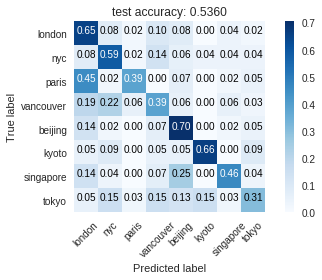

In [0]:
### hyperparameters ###
dir_name = 'transfered'
units, pooling, loss_weights = 512, 'avg', (0.5, 1)
base_name = '{}-{}-{}vs{}-random_state41-8cities'.format(units, pooling, *loss_weights)

model = create_model(
    n_class2=len(cities),
    n_class1=2,
    weights='places',
    pooling=pooling,
    units=units,
    drop_rate=0.5,
    optimizer='nadam',
    loss_weights=loss_weights,
)
model.summary()

train_gen, default_steps, (label2class1, label2class2) = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='train',
    batch_size=batch_size,
    random_state=42,
)
steps_per_epoch = default_steps * augment_times
valid_gen, validation_steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='validate',
    batch_size=batch_size,
    random_state=42,
)

epochs = 50
rlr = ReduceLROnPlateau(
    monitor='val_output2_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=2,
)
ss = SnapShot(
    dir_path, dir_name, base_name, monitor='val_output2_acc', mode='max')
cl = Logger(dir_path, dir_name, base_name)

hist = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[
        rlr,
        ss,
        cl,
    ],
    verbose=2,
)

######## test below #######

X_test, (y1_test, y2_test), (label2class1, label2class2) = get_test_data(
    gc_path=gc_path,
    cities=cities,
    batch_size=batch_size,
    random_state=42,
)

classes1 = [c for l, c in label2class1]
classes2 = [c for l, c in label2class2]

### test with the final model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.final'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.final'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### test with the best model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

model = load_model(
    os.path.join(dir_path, 'models', dir_name, base_name + '.best.h5'))

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.best'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.best'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

#### fine-tune

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

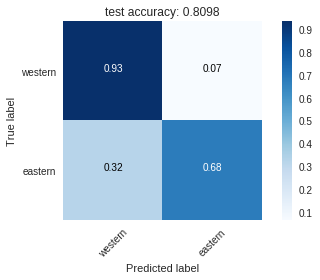

----- test -----
accuracy: 0.5562 %
             precision    recall  f1-score   support

     london     0.3929    0.6735    0.4962        49
        nyc     0.5077    0.6471    0.5690        51
      paris     0.7241    0.4773    0.5753        44
  vancouver     0.3939    0.3611    0.3768        36
    beijing     0.6341    0.5909    0.6118        44
      kyoto     0.7959    0.6964    0.7429        56
  singapore     0.5909    0.4643    0.5200        28
      tokyo     0.6250    0.3846    0.4762        39

avg / total     0.5896    0.5562    0.5587       347

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category2-512-avg-0.5vs1-random_state41-8cities-15.final.png


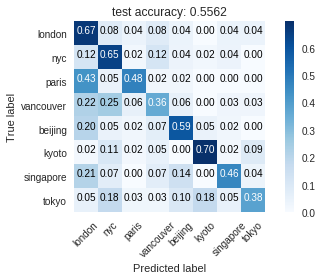

Found 347 images belonging to 8 classes.
----- test -----
accuracy: 0.8098 %
             precision    recall  f1-score   support

    western     0.7545    0.9389    0.8366       180
    eastern     0.9106    0.6707    0.7724       167

avg / total     0.8296    0.8098    0.8057       347

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category1-512-avg-0.5vs1-random_state41-8cities-15.best.png


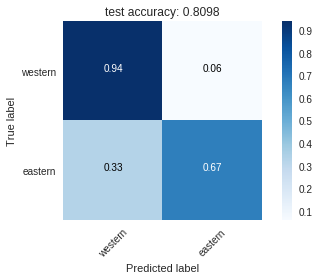

----- test -----
accuracy: 0.5562 %
             precision    recall  f1-score   support

     london     0.3882    0.6735    0.4925        49
        nyc     0.5077    0.6471    0.5690        51
      paris     0.7241    0.4773    0.5753        44
  vancouver     0.3939    0.3611    0.3768        36
    beijing     0.6341    0.5909    0.6118        44
      kyoto     0.7959    0.6964    0.7429        56
  singapore     0.6190    0.4643    0.5306        28
      tokyo     0.6250    0.3846    0.4762        39

avg / total     0.5912    0.5562    0.5590       347

figure saved successfully to G/My Drive/prj/figs/fine-tuned/category2-512-avg-0.5vs1-random_state41-8cities-15.best.png


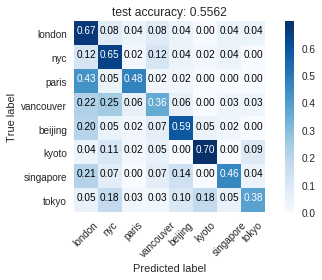

In [0]:
### hyperparameters ###
dir_name = 'fine-tuned'
trans_name = '512-avg-0.5vs1-random_state41-8cities'
model_file_path = os.path.join(dir_path, 'models', 'transfered', trans_name + '.best.h5')
freeze = 15

model = set_fine_tune(
    model_file_path,
    freeze=freeze,
    # optimizer=SGD(lr=1e-4, momentum=0.9, nesterov=True),
    loss_weights=None, # gonna use the same weights
)
model.summary()

base_name = '{}-{}'.format(trans_name, freeze)

train_gen, default_steps, (label2class1, label2class2) = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='train',
    batch_size=batch_size,
    random_state=42,
)
steps_per_epoch = default_steps * augment_times
valid_gen, validation_steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='validate',
    batch_size=batch_size,
    random_state=42,
)

epochs = 100
rlr = ReduceLROnPlateau(
    monitor='val_output2_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=2)
ss = SnapShot(
    dir_path, dir_name, base_name, monitor='val_output2_acc', mode='max')
cl = Logger(dir_path, dir_name, base_name)

hist = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    callbacks=[
        rlr,
        ss,
        cl,
    ],
    verbose=2,
)

######## test below #######

X_test, (y1_test, y2_test), (label2class1, label2class2) = get_test_data(
    gc_path=gc_path,
    cities=cities,
    batch_size=batch_size,
    random_state=42,
)

classes1 = [c for l, c in label2class1]
classes2 = [c for l, c in label2class2]

### test with the final model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.final'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.final'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)

### test with the best model ###

pred_gen, steps, _ = create_generator_gc(
    gc_path=gc_path,
    cities=cities,
    mode='predict',
    batch_size=batch_size,
    random_state=42,
)

model = load_model(
    os.path.join(dir_path, 'models', dir_name, base_name + '.best.h5'))

y1_test_pred, y2_test_pred = model.predict_generator(
    generator=pred_gen,
    steps=steps,
    verbose=2,
)

fig_name = 'category1-' + base_name + '.best'
report(np.argmax(y1_test, axis=1), np.argmax(y1_test_pred, axis=1), 'test', classes1,
       dir_path, dir_name, fig_name)

fig_name = 'category2-' + base_name + '.best'
report(
    np.argmax(y2_test, axis=1), np.argmax(y2_test_pred, axis=1), 'test',
    classes2, dir_path, dir_name, fig_name)